# Fashion Mnist
Fashion MNist es un dataset que contiene imágenes de ropa con fines académicos de aprender a crear un sistema de clasificación.

## Redes Neuronales Completamente Conectadas
Este es el sistema que usaremos para resolver el problema.

In [1]:
# Importando las librerías
from fashion_mnist_master.utils.mnist_reader import load_mnist
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import itertools

In [2]:
## Importando la data
X_train, y_train = load_mnist('fashion_mnist_master/data/fashion', kind='train')
X_test, y_test = load_mnist('fashion_mnist_master/data/fashion', kind='t10k')

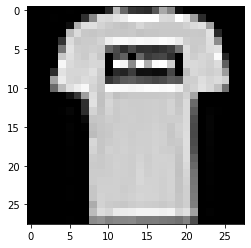

In [3]:
## Gráficando un elemento 
X = np.array(X_train[1])
X = X.reshape((28, 28))
## Poniéndolo en blanco y negro
fig, ax = plt.subplots()
ax.imshow(X, interpolation='nearest', cmap='gray')
plt.show()

Tras ver la data por anticipado, se puede notar que existen valores entre 0 y 255 para identificar la intensidad de color de bits en la imagen. Debido a que los números están demasiado grandes. Por éso se procede a aplicarles una reducción a través de la variable _chiquitolina_. 

In [4]:
#### Transformación de X_train
chiquitolina = (1/1) # Para achiquitar los valores
X_train = X_train[0:10000] * (chiquitolina)
X_train = X_train.astype(np.float32)

In [5]:
np.random.seed(0) # Semilla de aleatoriedad constante
np.seterr(divide = 'ignore')  # Por log(0) que sabemos es -inf

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [6]:
## X_train tiene la siguiente forma
### (observaciones, atributos)
### Cada elemento del array es una observación. 
### Según mi documento oficial juandieguístico tiene la forma n*m
L = 4 # Capas desde la X hasta la Y
### One-hot enconding para Y
y_train = y_train[0:10000]
y_train_one_hot = np.zeros((y_train.size, y_train.max()+1))
y_train_one_hot[np.arange(y_train.size),y_train] = 1
y_solver = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).T

### Funciones propias de la Red Neuronal y capas de activación
Las funciones que servirán como parámetros para la aplicación de _optimize_.

In [7]:
## FUNCIONES IMPORTANTES
def funcion_sigmoide(x, tetas):
    """Realiza la función sigmoide
        para cualquier parámetro teta
    """
    return np.power((1 + np.exp(-1 * np.dot(x, tetas.T)) ), -1).astype(np.float16)

#### Función de costo usada para multiclase
$$
E_{-x} = - \sum_{k}[t_k^x \log(o_k^x) + (1-t_k^x) \log (1- o_k^x)]
$$

In [8]:
def funcion_costo(tetas, figuras, x, y):
    """Realiza la función de costo
        para cualquier parámetro teta
    """
    tetas = deschatar_thetas(tetas, figuras)
    neuronas = forward_propagation(tetas, x) # Multiplicación de tetas
    return np.sum(np.multiply(y, np.log( neuronas[L-1] )) + np.multiply((1-y), np.log(1 - neuronas[L-1]))  ) / -len(x)

In [9]:
def precision(y_pred, y):
    """Calcula la precisión del modelo con base
        a los valores reales y predichos de Y 
    """
    enconding = 0
    for i in range(len(y_pred)):
        valor = np.argmax(y_pred[i])
        if(valor == y[i]):
            enconding += 1 
        
    return enconding / len(y)

In [10]:
def funcion_costo_base_precision(tetas, figuras, x, y):
    """Realiza la función de costo
        para cualquier parámetro teta
    """
    tetas = deschatar_thetas(tetas, figuras)
    neuronas = forward_propagation(tetas, x) # Multiplicación de tetas
    y_label = np.dot(y, y_solver)
    return 1/(precision(neuronas[L-1], y_label))**2

### Variables de uso general para la red neuronal
Aquí irán las neuronas, tamaño del modelo, constantes multiplicadoras y capa de _bias_.

In [11]:
thetas = []
#### Cada elemento contiene un arreglo de thetas. 
####      Para el primero son c*m según el documento juandieguístico.
#### Después serán 5*5 y el último será 10*6
thetas1 = np.random.rand(100, 785) # X a capa1
thetas2 = np.random.rand(50, 101) # capa1 a 2
thetas3 = np.random.rand(10, 51) # capa2 a resultado
## agregando thetas
thetas.append(thetas1)
thetas.append(thetas2)
thetas.append(thetas3)

figuras = [(100, 785), (50, 101), (10, 51)]

unos = np.ones((len(X_train), 1)).astype(np.float32) ## agregar columna de unos

### Funciones de transformación de thetas para Scipy optimize
Los multiplicadores deben de entregarse en un arreglo plano, por lo que hay funciones para aplanarlo y desaplanarlo.

In [12]:
def achatar_thetas(tetas):
    achatadas = np.array([])
    for i in tetas:
        achatadas = np.append(achatadas, i.flatten())
    achatadas.flatten()
    return achatadas

def deschatar_thetas(tetas, figura):
    deschatadas = []
    inicio = 0
    fin = 0
    for i in figura:
        fin = inicio + i[1]*i[0]
        deschatadas.append(np.array(tetas[inicio:fin]).reshape(i))
        inicio = fin
    return deschatadas

### Funciones NN

In [13]:
def forward_propagation(tetas, x):
    neuronas = [None] * L
    neuronas[0] = x ## agregando la primera capa
    for i in range(len(tetas)):
        ###### La siguiente neurona
        # print(i)
        # print(neuronas[i].shape)
        # print((np.append(neuronas[i], unos, axis=1)).shape)
        # print(neuronas[i])
        # capa_mas_bias = np.append(neuronas[i], unos, axis=1) # neurona actual más capa de unos (bias)
        neuronas[i + 1] = funcion_sigmoide(
            np.append(neuronas[i], unos, axis=1), tetas[i]) # Thetas actuales (ya incluyen la capa bias)
    return neuronas

In [14]:
def back_propagation(tetas, figuras, x, y):
    tetas = deschatar_thetas(tetas, figuras)
    # Back propagation
    # Forward Propagation (Paso 2.2)
    neuronas = forward_propagation(tetas, x)
    # Paso 1 y 2.1
    Deltas = [i * 0.0 for i in tetas]
    deltas = [i * 0.0 for i in neuronas]
    deltas[L - 1] = neuronas[L - 1] - y # Paso 2.3 del documento de Samuel Chávez
    for l in reversed(range(0, L - 1)):
        # Paso 2.4
        deltas[l] = np.multiply(
                np.dot(tetas[l].T[:-1], deltas[l + 1].T).T,
                np.multiply(
                    neuronas[l],
                    (1 - neuronas[l])
                    ))
        
        # Paso 2.5
        Deltas[l] = Deltas[l] + np.dot(deltas[l + 1].T,
                                       np.append(neuronas[l],
                                                 unos, axis=1))
        # Paso 3
        Deltas[l] = Deltas[l] * (1/len(x))
    return achatar_thetas(Deltas)

## Implementación con Optimize

In [15]:
thetas = achatar_thetas(thetas)
print(thetas, thetas.shape)
costo = funcion_costo(thetas, figuras, X_train, y_train_one_hot)
print("Costo actual: (antes de optimizar)", costo)
# Le quité la creación de neuronas, por éso está comentado
thetas = deschatar_thetas(thetas, figuras)
neuronas = forward_propagation(thetas, X_train)
print("Precisión antes de optimizar: ", precision(neuronas[L - 1], y_train))
thetas = achatar_thetas(thetas)

[0.5488135  0.71518937 0.60276338 ... 0.46419364 0.04709377 0.17385815] (84060,)


c:\users\juan diego\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


Costo actual: (antes de optimizar) nan
Precisión antes de optimizar:  0.0942


In [16]:
res = op.minimize(
    fun=funcion_costo,
    x0=thetas,
    args=(figuras, X_train, y_train_one_hot),
    method='L-BFGS-B',
    jac=back_propagation,
    options={'disp': True, 'maxiter': 1300})
res

c:\users\juan diego\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


      fun: 3.2500903076171874
 hess_inv: <84060x84060 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  0.        ,  0.        , ..., -0.00020752,
       -0.00020752, -0.00020752])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 35
      nit: 10
   status: 0
  success: True
        x: array([ 0.5488135 ,  0.71518937,  0.60276338, ..., -0.05927228,
       -0.47637216, -0.34960777])

In [17]:
thetas = res.x
print(thetas)
costo = funcion_costo(thetas, figuras, X_train, y_train_one_hot)
# Necesita las Thetas deschatadas
thetas = deschatar_thetas(thetas, figuras)
neuronas = forward_propagation(thetas, X_train)
print(costo)
print(precision(neuronas[L - 1], y_train))

[ 0.5488135   0.71518937  0.60276338 ... -0.05927228 -0.47637216
 -0.34960777]
3.2500903076171874
0.1027


## Justificación de mi estructura de NN
### ¿Por qué 4 capas ocultas y 5 neuronas?
En clase estuvimos discutiendo acerca del _Vanishing Gradient Problem_ , y que este se da al superar el número aproximado de 5. Es decir que con el modelo actual de la función Sigmoide tener más de 5 neuronas y 5 capas ocultas haría gradientes muy pequeños, que casi tienden a 0. 

Al ver los beneficios con pocas capas y con varias, 5 capas y 5 neuronas dieron un excelente resultado.

### Resultados en el training set

In [18]:
unos = np.ones((len(X_test), 1)).astype(np.float32) ## agregar columna de unos
neuronas = forward_propagation(thetas, X_test)
print("{} de precisión (sobre 100%) alcanzado en el testing set".format(precision(neuronas[L - 1], y_test)))

0.1 de precisión (sobre 100%) alcanzado en el testing set
